### Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import snowflake.connector
from snowflake.connector.pandas_tools import write_pandas
from scipy.stats import pointbiserialr
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm

### Load Data

In [2]:
# snowlake connection
conn = snowflake.connector.Connect(user='ANALYST', password='Fedewap2023!', account='rl43903.east-us-2.azure')

In [3]:
#SQL Queries
sql = 'SELECT * FROM CHICAGOFIRE_DATABASE.MLS.MODEL_CF where SEASON_TICKET_HOLDER = 1 and seasonyear like any (2021, 2022)'
sql2 = "SELECT DW_ID, SEASON_TICKET_HOLDER, seasonyear, first_name_c, LAST_NAME_C, RENEWED_NEXT_YEAR, MLS_TENURE, ORDER_QUANTITY_M, ORDER_QUANTITY_M_LAST_YEAR, ORDER_QUANTITY_M_ALL_TIME, ORDER_SPEND_M, ORDER_SPEND_M_LAST_YEAR, ORDER_SPEND_M_ALL_TIME, TICKET_QUANTITY_T, TICKET_QUANTITY_LAST_YEAR, TICKET_QUANTITY_ALL_TIME, COUNT_OF_MLS_EVENTS, COUNT_OF_MLS_EVENTS_LAST_YEAR, COUNT_OF_MLS_EVENTS_ALL_TIME, TICKET_SPEND_T, TICKET_SPEND_T_LAST_YEAR, TICKET_SPEND_T_ALL_TIME, ADHOC_CREATEDDATE, CLUBTICKETPURCHASE_CREATEDDATE, CLUBTICKETPURCHASE_RESALE_CREATEDDATE, EA_FIFA_CREATEDDATE, ECAL_CREATEDDATE, GIGYA_FANTASY_CREATEDDATE, GIGYA_MLSSOCCERWEBSITE_CREATEDDATE, GIGYA_MLSMOBILEAPP_CREATEDDATE, MLSLIVE_CREATEDDATE, MLSSTORE_PURCHASE_CREATEDDATE, MLSSTORE_SUBSCRIBER_CREATEDDATE, NEWSLETTER_SUBSCRIBERS_CREATEDDATE, SUMTM_CREATEDDATE, USERINTERACTIVE_CREATEDDATE, MLSLEAGUEEVENT_CREATEDDATE, MLSBRACKETCHALLENGE_CREATEDDATE, MLSALLSTARVOTING_CREATEDDATE, PARTNERDATAACTIVATION_CREATEDDATE, MLSLEAGUETICKETGAMEEVENT_CREATEDDATE, FREETOPLAY_CREATEDDATE, SINGLE_GAME_FLAG, PREV_SINGLE_GAME_FLAG, COMP_FLAG, PREV_COMP_FLAG, GROUP_FLAG, PREV_GROUP_FLAG, FULL_SEASON_FLAG, PREV_FULL_SEASON_FLAG, PARTIAL_SEASON_FLAG, PREV_PARTIAL_SEASON_FLAG, DISTANCE_TO_STADIUM_C, EA_FIFA_C, EA_FIFA_OPT_IN_C, MARKETING_OPTIN_FLAG_C, AGE_RANGE_L, CASE WHEN AGE_RANGE_L = '18-29' THEN '1' WHEN AGE_RANGE_L = '30-39' THEN '2' WHEN AGE_RANGE_L = '40-49' THEN '3' WHEN AGE_RANGE_L = '50-59' THEN '4' WHEN AGE_RANGE_L = '60-69' THEN '5' WHEN AGE_RANGE_L = '70+' THEN '6' END AS AGE_BUCKET, CASE WHEN GENDER_L = 'Male' THEN 1 WHEN GENDER_L = 'Female' THEN 0 END AS GENDER_BIN, GENDER_L, NUMBER_OF_ADULTS_L, EDUCATION_L, CASE WHEN EDUCATION_L = 'Completed High School' THEN '1' WHEN EDUCATION_L = 'Completed College' THEN '2' WHEN EDUCATION_L = 'Completed Graduate School' THEN '3' WHEN EDUCATION_L = 'Attended Vocational/Technical' THEN '4' END AS EDUCATION_BUCKET, PREMIUM_BUYER_L, ANCILLARY_BUYER_L, HIGH_SPENDERS_L, TRAVELERS_L, HOUSEHOLD_INCOME_RANGE_L, CASE WHEN HOUSEHOLD_INCOME_RANGE_L = '0-25K' THEN '1' WHEN HOUSEHOLD_INCOME_RANGE_L = '25-50K' THEN '2' WHEN HOUSEHOLD_INCOME_RANGE_L = '50-75K' THEN '3' WHEN HOUSEHOLD_INCOME_RANGE_L = '75-100K' THEN '4' WHEN HOUSEHOLD_INCOME_RANGE_L = '100-125K' THEN '5' WHEN HOUSEHOLD_INCOME_RANGE_L = '125K+' THEN '6' END AS HOUSEHOLD_INCOME_BUCKET, MARITAL_STATUS_L, CASE WHEN MARITAL_STATUS_L = 'Married' THEN 1 WHEN MARITAL_STATUS_L = 'Single' THEN 0 END AS MARITAL_BUCKET, RACE_L, CASE WHEN RACE_L = 'W' THEN 1 WHEN RACE_L = 'H' THEN 2 WHEN RACE_L = 'A' THEN 3 WHEN RACE_L = 'B' THEN 4 END AS RACE_BUCKET, MERCH_OPTIN_FLAG_M, MERCH_ORDERS_ALL_TIME_M, PRODUCTS_BOUGHT_ALL_TIME_M, MERCH_SPEND_ALL_TIME_M, MERCH_LAST_PURCHASE_DATE_M, DATEDIFF('day', MERCH_LAST_PURCHASE_DATE_M, CURRENT_DATE) AS DAYS_SINCE_LAST_MERCH__PURCHASE_DATE, TICKET_QUANTITY_ALL_T, TICKET_SPEND_ALL_TIME_T, LAST_MLS_EVENT_ATTENDED_T, CATEGORY_T, SINGLE_GAME_FLAG_T, COMP_FLAG_T, GROUP_FLAG_T, NEW_FULL_SEASON_FLAG_T, PARTIAL_SEASON_FLAG_T, RENEW_FULL_SEASON_FLAG_T, FORMER_FULL_SEASON_T, PREMIUM_FLAG_T, SUPPORTER_FLAG_T, LAST_EVENT_ATTENDED_DATE, ANNUAL_EVENTS_ATTENDED, PREV_YR_EVENTS_ATTENDED FROM CHICAGOFIRE_DATABASE.MLS.MODEL_CF WHERE SEASON_TICKET_HOLDER = 1 AND seasonyear LIKE ANY (2022)" # 2021 was removed. Sean building it in for rn
sql3 = "SELECT main.*, sub.COUNT_SINGLE_ADVANCE, sub.COUNT_COMPLIMENTARY, taskdata.TASK_COUNT_EMAIL, taskdata.TASK_COUNT_LISTEMAIL, taskdata.TASK_COUNT_CALL, taskdata.TASK_COUNT_TASK, taskdata.TASK_COUNT_CADENCE FROM (SELECT model.DW_ID, model.FIRST_NAME_C, model.LAST_NAME_C, model.seasonyear, model.RENEWED_NEXT_YEAR, model.MLS_TENURE, model.ORDER_QUANTITY_M, model.ORDER_QUANTITY_M_LAST_YEAR, model.ORDER_QUANTITY_M_ALL_TIME, model.ORDER_SPEND_M, model.ORDER_SPEND_M_LAST_YEAR, model.ORDER_SPEND_M_ALL_TIME, model.TICKET_QUANTITY_T, model.TICKET_QUANTITY_LAST_YEAR, model.TICKET_QUANTITY_ALL_TIME, model.COUNT_OF_MLS_EVENTS, model.COUNT_OF_MLS_EVENTS_LAST_YEAR, model.COUNT_OF_MLS_EVENTS_ALL_TIME, model.TICKET_SPEND_T, model.TICKET_SPEND_T_LAST_YEAR, model.TICKET_SPEND_T_ALL_TIME, model.SINGLE_GAME_FLAG, model.PREV_SINGLE_GAME_FLAG, model.COMP_FLAG, model.PREV_COMP_FLAG, model.GROUP_FLAG, model.PREV_GROUP_FLAG, model.FULL_SEASON_FLAG, model.PREV_FULL_SEASON_FLAG, model.PARTIAL_SEASON_FLAG, model.PREV_PARTIAL_SEASON_FLAG, model.prev_yr_events_attended, model.DISTANCE_TO_STADIUM_C FROM CHICAGOFIRE_DATABASE.MLS.MODEL_CF as model WHERE model.SEASON_TICKET_HOLDER = 1 AND model.seasonyear LIKE ANY (2022)) as main LEFT JOIN (SELECT id_table.DW_ID, SUM(CASE WHEN arch.TICKET_TYPE_CATEGORY = '6-Single Advance' THEN 1 ELSE 0 END) AS COUNT_SINGLE_ADVANCE, SUM(CASE WHEN arch.TICKET_TYPE_CATEGORY = 'Complimentary' THEN 1 ELSE 0 END) AS COUNT_COMPLIMENTARY FROM (SELECT model.DW_ID, master.ACCT_ID_T FROM CHICAGOFIRE_DATABASE.MLS.MODEL_CF as model LEFT JOIN CHICAGOFIRE_DATABASE.MLS.MASTER_CF as master ON model.DW_ID = master.DW_ID_MASTER WHERE model.SEASONYEAR in (2021, 2022) and model.SEASON_TICKET_HOLDER = 1) AS id_table INNER JOIN CHICAGOFIRE_DATABASE.ARCHTICS.ARCHITCS_2022 as arch ON id_table.ACCT_ID_T = arch.ACCT_ID GROUP BY id_table.DW_ID) as sub ON main.DW_ID = sub.DW_ID LEFT JOIN (SELECT model.DW_ID, model.FIRST_NAME_C, model.LAST_NAME_C, opp.CONTACTID__C, SUM(CASE WHEN task.TASKSUBTYPE = 'Email' THEN 1 ELSE 0 END) AS TASK_COUNT_EMAIL, SUM(CASE WHEN task.TASKSUBTYPE = 'List Email' THEN 1 ELSE 0 END) AS TASK_COUNT_LISTEMAIL, SUM(CASE WHEN task.TASKSUBTYPE = 'Call' THEN 1 ELSE 0 END) AS TASK_COUNT_CALL, SUM(CASE WHEN task.TASKSUBTYPE = 'Task' THEN 1 ELSE 0 END) AS TASK_COUNT_TASK, SUM(CASE WHEN task.TASKSUBTYPE = 'Cadence' THEN 1 ELSE 0 END) AS TASK_COUNT_CADENCE FROM CHICAGOFIRE_DATABASE.SALESFORCE.SF_OPPORTUNITIES as opp INNER JOIN CHICAGOFIRE_DATABASE.SALESFORCE.SF_TASK as task ON task.WHOID = opp.CONTACTID__C INNER JOIN CHICAGOFIRE_DATABASE.MLS.MODEL_CF as model ON model.ACCT_ID_T = opp.TICKET_ID__C WHERE task.ACTIVITYDATE BETWEEN '2022-08-01' AND '2023-06-01' GROUP BY model.DW_ID, model.FIRST_NAME_C, model.LAST_NAME_C, opp.CONTACTID__C) as taskdata ON main.DW_ID = taskdata.DW_ID"

In [5]:
#Not sure what this does but yk
res = conn.cursor().execute(sql).fetchall()


In [7]:
#load in dataset
df = pd.read_sql(sql, conn)
df.head()

C:\Users\dgilbert\AppData\Local\Temp\ipykernel_4908\3423439497.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, conn)


,DW_ID,SEASONYEAR,SEASON_TICKET_HOLDER,RENEWED_NEXT_YEAR,SINCE_DATE,MLST_SINCE_DATE,MLS_TENURE,ORDER_QUANTITY_M,ORDER_QUANTITY_M_LAST_YEAR,ORDER_QUANTITY_M_ALL_TIME,...,LAST_EVENT_ATTENDED_DATE,EVENT_NAME,LAST_EVENT_SECTION,ANNUAL_EVENTS_ATTENDED,PREV_YR_EVENTS_ATTENDED,LIFETIME_EVENTS_ATTENDED,CURRENT_ATTENDANCE_STREAK,LONGEST_ATTENDANCE_STREAK,NEXT_EVENT_DATE_N,NEXT_SECTION_N
0,9542384,2021,1,0,0,0,1045,0,0,0,...,None,None,None,0,0,2,0,0,None,None
1,9543133,2022,1,0,0,0,1254,0,0,2,...,None,None,None,0,0,0,0,0,None,None
2,9545883,2022,1,0,0,0,1152,0,0,0,...,None,None,None,0,8,8,0,0,None,None
3,9559023,2022,1,1,0,0,1128,0,0,2,...,2023-10-07,FIR1007,132,2,3,5,1,1,None,None
4,9563536,2021,1,0,1,1,333,0,0,0,...,None,None,None,0,1,2,0,0,None,None


### Begin EDA

In [8]:
df.shape
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3908 entries, 0 to 3907
Columns: 152 entries, DW_ID to NEXT_SECTION_N
dtypes: float64(18), int64(73), object(61)
memory usage: 4.5+ MB


,DW_ID,SEASON_TICKET_HOLDER,RENEWED_NEXT_YEAR,SINCE_DATE,MLST_SINCE_DATE,MLS_TENURE,ORDER_QUANTITY_M,ORDER_QUANTITY_M_LAST_YEAR,ORDER_QUANTITY_M_ALL_TIME,ORDER_SPEND_M,...,PARTIAL_SEASON_FLAG_T,RENEW_FULL_SEASON_FLAG_T,FORMER_FULL_SEASON_T,PREMIUM_FLAG_T,SUPPORTER_FLAG_T,ANNUAL_EVENTS_ATTENDED,PREV_YR_EVENTS_ATTENDED,LIFETIME_EVENTS_ATTENDED,CURRENT_ATTENDANCE_STREAK,LONGEST_ATTENDANCE_STREAK
count,3.908000e+03,3908.0,3908.000000,3908.000000,3908.000000,3908.000000,3908.000000,3908.000000,3908.000000,3908.000000,...,3908.000000,3908.000000,3908.000000,3908.000000,3908.000000,3908.000000,3908.000000,3908.000000,3908.000000,3908.000000
mean,5.487572e+06,1.0,0.628454,0.044268,0.082907,2880.209570,0.605169,0.644575,2.224156,85.250548,...,0.045803,0.520727,0.876919,0.025844,0.116684,3.914534,5.327021,11.711361,0.718014,1.962897
std,4.927265e+06,0.0,0.483280,0.205717,0.275777,1861.336587,2.332145,2.706026,6.501986,485.833863,...,0.209085,0.499634,0.328572,0.158691,0.321084,4.678271,4.526182,10.261994,2.010801,2.784267
min,3.137200e+04,1.0,0.000000,0.000000,0.000000,69.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.771740e+05,1.0,0.000000,0.000000,0.000000,1353.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000
50%,4.130188e+06,1.0,1.000000,0.000000,0.000000,2664.500000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,5.000000,9.000000,0.000000,1.000000
75%,9.725370e+06,1.0,1.000000,0.000000,0.000000,3984.000000,0.000000,0.000000,2.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,7.000000,9.000000,19.000000,0.000000,3.000000
max,1.866155e+07,1.0,1.000000,1.000000,1.000000,9158.000000,75.000000,75.000000,140.000000,18864.010000,...,1.000000,1.000000,1.000000,1.000000,1.000000,17.000000,17.000000,43.000000,17.000000,17.000000


In [9]:
#reformat and drop cols
df['SEASONYEAR'] = df['SEASONYEAR'].astype('int64')
df = df.set_index('DW_ID')
df_corr = df.drop(columns=['FIRST_NAME_C', 'LAST_NAME_C'])

In [12]:
df_corr

,SEASONYEAR,SEASON_TICKET_HOLDER,RENEWED_NEXT_YEAR,SINCE_DATE,MLST_SINCE_DATE,MLS_TENURE,ORDER_QUANTITY_M,ORDER_QUANTITY_M_LAST_YEAR,ORDER_QUANTITY_M_ALL_TIME,ORDER_SPEND_M,...,LAST_EVENT_ATTENDED_DATE,EVENT_NAME,LAST_EVENT_SECTION,ANNUAL_EVENTS_ATTENDED,PREV_YR_EVENTS_ATTENDED,LIFETIME_EVENTS_ATTENDED,CURRENT_ATTENDANCE_STREAK,LONGEST_ATTENDANCE_STREAK,NEXT_EVENT_DATE_N,NEXT_SECTION_N
DW_ID,,,,,,,,,,,,,,,,,,,,,
9542384,2021,1,0,0,0,1045,0,0,0,0.00,...,None,None,None,0,0,2,0,0,None,None
9543133,2022,1,0,0,0,1254,0,0,2,0.00,...,None,None,None,0,0,0,0,0,None,None
9545883,2022,1,0,0,0,1152,0,0,0,0.00,...,None,None,None,0,8,8,0,0,None,None
9559023,2022,1,1,0,0,1128,0,0,2,0.00,...,2023-10-07,FIR1007,132,2,3,5,1,1,None,None
9563536,2021,1,0,1,1,333,0,0,0,0.00,...,None,None,None,0,1,2,0,0,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1027470,2022,1,1,0,0,1275,1,3,8,143.55,...,2023-10-04,FIR1004,141,5,5,15,0,3,None,None
1028361,2022,1,0,0,0,3277,0,0,1,0.00,...,None,None,None,0,1,1,0,0,None,None
1028361,2021,1,1,0,0,2912,0,0,1,0.00,...,None,None,None,0,1,1,0,0,None,None


In [12]:
corr = df_corr.corr()
corr.to_csv("C:/Users/dgilbert/Desktop/Code/correlation_matrix.csv")

In [13]:
df_corr['HOUSEHOLD_INCOME_BUCKET'] = df_corr['HOUSEHOLD_INCOME_BUCKET'].fillna(0)
df_corr['HOUSEHOLD_INCOME_BUCKET'] = df_corr['HOUSEHOLD_INCOME_BUCKET'].replace('1', 1)
df_corr['HOUSEHOLD_INCOME_BUCKET'] = df_corr['HOUSEHOLD_INCOME_BUCKET'].replace('2', 2)
df_corr['HOUSEHOLD_INCOME_BUCKET'] = df_corr['HOUSEHOLD_INCOME_BUCKET'].replace('3', 3)
df_corr['HOUSEHOLD_INCOME_BUCKET'] = df_corr['HOUSEHOLD_INCOME_BUCKET'].replace('4', 4)
df_corr['HOUSEHOLD_INCOME_BUCKET'] = df_corr['HOUSEHOLD_INCOME_BUCKET'].replace('5', 5)
df_corr['HOUSEHOLD_INCOME_BUCKET'] = df_corr['HOUSEHOLD_INCOME_BUCKET'].replace('6', 6)

KeyError: 'HOUSEHOLD_INCOME_BUCKET'

In [ ]:
pointbiserialr(df_corr['HOUSEHOLD_INCOME_BUCKET'], df_corr['RENEWED_NEXT_YEAR'])

KeyError: 'HOUSEHOLD_INCOME_BUCKET'

In [ ]:
df_corr['RENEWED_NEXT_YEAR'].to_list()

[1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,


In [14]:
#Nick's Code

"""
library(plyr)
library(dplyr)
library(caret)
library(ggplot2)
library(pROC)

## IMPORT ##
#df via copy paste
df <- read.delim("clipboard")

#df via csv read in proj. folder
#ggplot(df, aes(x = DISTANCE_TO_STADIUM_C)) + geom_histogram(binwidth = 1)
## EDA ##
#Summary of all vars
#summary(df)

## DATA CLEANING ##
#Drop filter these records out:
# dw_id	acct_id
# 3790591	295808
# 348953
# 31405	  114785
# 4513005	3496760
df <- subset(df, DW_ID!=3790591 & 
               DW_ID!=348953 &
               DW_ID!=31405 &
               DW_ID!=4513005 &
               DW_ID!=295808 &
               DW_ID!=114785 &
               DW_ID!=3496760)


#Race
df$RACE_L[is.na(df$RACE_L)] <- "O"
df$RACE_L[df$RACE_L == ""] <- "O"
df$RACE_L[df$RACE_L == "A"] <- "O"
df$RACE_L[df$RACE_L == "B"] <- "O"
df$RACE_L <- factor(df$RACE_L)

#Income
df$HOUSEHOLD_INCOME_RANGE_L[df$HOUSEHOLD_INCOME_RANGE_L == ""] <- "NA"
df$HOUSEHOLD_INCOME_RANGE_L <- factor(df$HOUSEHOLD_INCOME_RANGE_L)

#NA's = 0 Cleaning

df$TICKET_QUANTITY_LAST_YEAR_T[is.na(df$TICKET_QUANTITY_LAST_YEAR_T)] <- 0
df$TICKET_QUANTITY_THIS_YEAR_T[is.na(df$TICKET_QUANTITY_THIS_YEAR_T)] <- 0
df$TICKET_QUANTITY_ALL_T[is.na(df$TICKET_QUANTITY_ALL_T)] <- 0

df$TICKET_SPEND_LAST_YEAR_T[is.na(df$TICKET_SPEND_LAST_YEAR_T)] <- 0
df$TICKET_SPEND_THIS_YEAR_T[is.na(df$TICKET_SPEND_THIS_YEAR_T)] <- 0
df$TICKET_SPEND_ALL_TIME_T[is.na(df$TICKET_SPEND_ALL_TIME_T)] <- 0

df$MERCH_ORDERS_THIS_YEAR_M[is.na(df$MERCH_ORDERS_THIS_YEAR_M)] <- 0
df$MERCH_ORDERS_LAST_YEAR_M[is.na(df$MERCH_ORDERS_LAST_YEAR_M)] <- 0
df$MERCH_ORDERS_ALL_TIME_M[is.na(df$MERCH_ORDERS_ALL_TIME_M)] <- 0

df$MERCH_SPEND_THIS_YEAR_M[is.na(df$MERCH_SPEND_THIS_YEAR_M)] <- 0
df$MERCH_SPEND_LAST_YEAR_M[is.na(df$MERCH_SPEND_LAST_YEAR_M)] <- 0
df$MERCH_SPEND_ALL_TIME_M[is.na(df$MERCH_SPEND_ALL_TIME_M)] <- 0

df$ANNUAL_EVENTS_ATTENDED[is.na(df$ANNUAL_EVENTS_ATTENDED)] <- 0
df$PREV_YR_EVENTS_ATTENDED[is.na(df$PREV_YR_EVENTS_ATTENDED)] <- 0
df$LIFETIME_EVENTS_ATTENDED[is.na(df$LIFETIME_EVENTS_ATTENDED)] <- 0

df$PRODUCTS_BOUGHT_THIS_YEAR_M[is.na(df$PRODUCTS_BOUGHT_THIS_YEAR_M)] <- 0
df$PRODUCTS_BOUGHT_LAST_YEAR_M[is.na(df$PRODUCTS_BOUGHT_LAST_YEAR_M)] <- 0
df$PRODUCTS_BOUGHT_ALL_TIME_M[is.na(df$PRODUCTS_BOUGHT_ALL_TIME_M)] <- 0

df$TICKET_SPEND_LAST_YEAR_SUM_T[is.na(df$TICKET_SPEND_LAST_YEAR_SUM_T)] <- 0
df$TICKET_SPEND_ALL_TIME_SUM_T[is.na(df$TICKET_SPEND_ALL_TIME_SUM_T)] <- 0
df$TICKET_SPEND_THIS_YEAR_SUM_T[is.na(df$TICKET_SPEND_THIS_YEAR_SUM_T)] <- 0

# Total Spend - Total Overall Spend
df$TotalSpend <- log(df$TICKET_SPEND_T + df$ORDER_SPEND_M)
df$TotalSpend[which(!is.finite(df$TotalSpend))] <- 0

# Spend per game - LOG(TICKET_SPEND_THIS_YEAR_T/ANNUAL_EVENTS_ATTENDED)
df$SpendPerGame <- log(df$TICKET_SPEND_T / df$COUNT_OF_MLS_EVENTS)
df$SpendPerGame[which(!is.finite(df$SpendPerGame))] <- 0

# Seats per game - Annual Seats/Annual Events
df$SeatsPerGame <- df$TICKET_QUANTITY_T / df$COUNT_OF_MLS_EVENTS

# Tenure
# Convert to years
df$MLS_TENURE <- df$MLS_TENURE / 365
# ANNUAL_EVENTS_ATTENDED
# Convert to attendance rate

df$MLS_TENURE <- log(df$MLS_TENURE)
df$TOTALSPEND <- log(df$TOTALSPEND)
df$TOTALSPEND[which(!is.finite(df$TOTALSPEND))] <- 0
df$SPENDPERGAME <- log(df$SPENDPERGAME)
df$SPENDPERGAME[which(!is.finite(df$SPENDPERGAME))] <- 0
df$RENEWED_NEXT_YEAR <- as.factor(df$RENEWED_NEXT_YEAR)
train$RENEWED_NEXT_YEAR <- as.factor(train$RENEWED_NEXT_YEAR)
test$RENEWED_NEXT_YEAR <- as.factor(test$RENEWED_NEXT_YEAR)


## MODEL ##
#Set params
set.seed(1017)
acc <- NULL
pbar <- create_progress_bar('text')
pbar$init(k)
k = 100

#Logistic Regression w/ K-folds CV
for (i in 1:k) {
  # Train-test splitting
  # 95% of samples -> fitting
  # 5% of samples -> testing
  smp_size <- floor(0.95 * nrow(df))
  index <- sample(seq_len(nrow(df)), size = smp_size)
  train <- df[index, ]
  test <- df[-index, ]
  
  # Fitting
  model <- glm(RENEWED_NEXT_YEAR ~ TOTALSPEND + SPENDPERGAME  + ATTEND_PERCENTAGE + MLS_TENURE,
               family = binomial,
               data = train)
  
  # Predict results
  preds <- predict(model, test, type = 'response')
  
  # If prob > 0.5 then 1, else 0
  results <- ifelse(preds > 0.5, 1, 0)
  
  # Actual answers
  answers <- test$RENEWED_NEXT_YEAR
  
  # Accuracy calculation
  misClasificError <- mean(answers != results)
  
  # Collecting results
  acc[i] <- 1 - misClasificError
  
  #progress bar add
  pbar$step()
}


#POST-ANALYSIS
#General
summary(model)
mean(acc)

#Correlation
df.cor <- data.frame(TotalSpenc=df$TotalSpend, 
                     SpendPerGame=df$SpendPerGame, 
                     ANNUAL_EVENTS_ATTENDED=df$ANNUAL_EVENTS_ATTENDED, 
                     MLS_TENURE=df$MLS_TENURE)
cor(df.cor)

#Residuals
residualPlots(model)
res <- resid(model)
plot(fitted(model), res)


#Goodness of Fit
1 - pchisq(q=model$null.deviance - model$deviance, df=length(coef(model)))

#RSquared
1 - (model$deviance / model$null.deviance)

#PREDICT 23
Predict <- read.delim("clipboard")
Predict <- subset(Predict, DW_ID!=3790591 & 
                    DW_ID!=348953 &
                    DW_ID!=31405 &
                    DW_ID!=4513005 &
                    DW_ID!=295808 &
                    DW_ID!=114785 &
                    DW_ID!=3496760)

#NA's = 0 Cleaning
Predict$TICKET_QUANTITY_LAST_YEAR_T[is.na(Predict$TICKET_QUANTITY_LAST_YEAR_T)] <- 0
Predict$TICKET_QUANTITY_THIS_YEAR_T[is.na(Predict$TICKET_QUANTITY_THIS_YEAR_T)] <- 0
Predict$TICKET_QUANTITY_ALL_T[is.na(Predict$TICKET_QUANTITY_ALL_T)] <- 0

Predict$TICKET_SPEND_LAST_YEAR_T[is.na(Predict$TICKET_SPEND_LAST_YEAR_T)] <- 0
Predict$TICKET_SPEND_THIS_YEAR_T[is.na(Predict$TICKET_SPEND_THIS_YEAR_T)] <- 0
Predict$TICKET_SPEND_ALL_TIME_T[is.na(Predict$TICKET_SPEND_ALL_TIME_T)] <- 0

Predict$MERCH_ORDERS_THIS_YEAR_M[is.na(Predict$MERCH_ORDERS_THIS_YEAR_M)] <- 0
Predict$MERCH_ORDERS_LAST_YEAR_M[is.na(Predict$MERCH_ORDERS_LAST_YEAR_M)] <- 0
Predict$MERCH_ORDERS_ALL_TIME_M[is.na(Predict$MERCH_ORDERS_ALL_TIME_M)] <- 0

Predict$MERCH_SPEND_THIS_YEAR_M[is.na(Predict$MERCH_SPEND_THIS_YEAR_M)] <- 0
Predict$MERCH_SPEND_LAST_YEAR_M[is.na(Predict$MERCH_SPEND_LAST_YEAR_M)] <- 0
Predict$MERCH_SPEND_ALL_TIME_M[is.na(Predict$MERCH_SPEND_ALL_TIME_M)] <- 0

Predict$ANNUAL_EVENTS_ATTENDED[is.na(Predict$ANNUAL_EVENTS_ATTENDED)] <- 0
Predict$PREV_YR_EVENTS_ATTENDED[is.na(Predict$PREV_YR_EVENTS_ATTENDED)] <- 0
Predict$LIFETIME_EVENTS_ATTENDED[is.na(Predict$LIFETIME_EVENTS_ATTENDED)] <- 0

Predict$PRODUCTS_BOUGHT_THIS_YEAR_M[is.na(Predict$PRODUCTS_BOUGHT_THIS_YEAR_M)] <- 0
Predict$PRODUCTS_BOUGHT_LAST_YEAR_M[is.na(Predict$PRODUCTS_BOUGHT_LAST_YEAR_M)] <- 0
Predict$PRODUCTS_BOUGHT_ALL_TIME_M[is.na(Predict$PRODUCTS_BOUGHT_ALL_TIME_M)] <- 0

Predict$TICKET_SPEND_LAST_YEAR_SUM_T[is.na(Predict$TICKET_SPEND_LAST_YEAR_SUM_T)] <- 0
Predict$TICKET_SPEND_ALL_TIME_SUM_T[is.na(Predict$TICKET_SPEND_ALL_TIME_SUM_T)] <- 0
Predict$TICKET_SPEND_THIS_YEAR_SUM_T[is.na(Predict$TICKET_SPEND_THIS_YEAR_SUM_T)] <- 0

# Total Spend - Total Overall Spend
Predict$TotalSpend <- log(Predict$TICKET_SPEND_T + Predict$ORDER_SPEND_M)
Predict$TotalSpend[which(!is.finite(Predict$TotalSpend))] <- 0

# Spend per game - LOG(TICKET_SPEND_THIS_YEAR_T/ANNUAL_EVENTS_ATTENDED)
Predict$SpendPerGame <- log(Predict$TICKET_SPEND_T / Predict$COUNT_OF_MLS_EVENTS)
Predict$SpendPerGame[which(!is.finite(Predict$SpendPerGame))] <- 0

# Seats per game - Annual Seats/Annual Events
Predict$SeatsPerGame <- Predict$TICKET_QUANTITY_T / Predict$COUNT_OF_MLS_EVENTS

# Tenure
# Convert to years
Predict$MLS_TENURE <- Predict$MLS_TENURE / 365
df$MLS_TENURE <- log(df$MLS_TENURE)

#Predict
new_preds <- predict(model, newdata = Predict, type = "response")
Predict$renewal <- new_preds

#Reorder
Predict <- Predict %>% relocate(ACCT_ID_T, .after = DW_ID)
Predict <- Predict %>% relocate(renewal, .after = ACCT_ID_T)
Predict <- Predict %>% relocate(TotalSpend, .after = renewal)
Predict <- Predict %>% relocate(SpendPerGame, .after = TotalSpend)
Predict <- Predict %>% relocate(ANNUAL_EVENTS_ATTENDED, .after = SpendPerGame)
Predict <- Predict %>% relocate(MLS_TENURE, .after = ANNUAL_EVENTS_ATTENDED)

#Export
write.csv(Predict, "C:\\Users\\nmoreno\\Downloads\\22Predictions.csv", row.names = TRUE)
"""

'\nlibrary(plyr)\nlibrary(dplyr)\nlibrary(caret)\nlibrary(ggplot2)\nlibrary(pROC)\n\n## IMPORT ##\n#df via copy paste\ndf <- read.delim("clipboard")\n\n#df via csv read in proj. folder\n#ggplot(df, aes(x = DISTANCE_TO_STADIUM_C)) + geom_histogram(binwidth = 1)\n## EDA ##\n#Summary of all vars\n#summary(df)\n\n## DATA CLEANING ##\n#Drop filter these records out:\n# dw_id\tacct_id\n# 3790591\t295808\n# 348953\n# 31405\t  114785\n# 4513005\t3496760\ndf <- subset(df, DW_ID!=3790591 & \n               DW_ID!=348953 &\n               DW_ID!=31405 &\n               DW_ID!=4513005 &\n               DW_ID!=295808 &\n               DW_ID!=114785 &\n               DW_ID!=3496760)\n\n\n#Race\ndf$RACE_L[is.na(df$RACE_L)] <- "O"\ndf$RACE_L[df$RACE_L == ""] <- "O"\ndf$RACE_L[df$RACE_L == "A"] <- "O"\ndf$RACE_L[df$RACE_L == "B"] <- "O"\ndf$RACE_L <- factor(df$RACE_L)\n\n#Income\ndf$HOUSEHOLD_INCOME_RANGE_L[df$HOUSEHOLD_INCOME_RANGE_L == ""] <- "NA"\ndf$HOUSEHOLD_INCOME_RANGE_L <- factor(df$HOUSEHOLD_I

### Data Cleaning

#### Drop vendor IDs

In [15]:
ids_to_drop = [3790591, 295808, 348953, 31405, 114785, 4513005, 3496760]
for id_ in ids_to_drop:
    if id_ in df.index:
        print(f"ID {id_} is in the DataFrame's index.")
    else:
        print(f"ID {id_} is NOT in the DataFrame's index.")


ID 3790591 is in the DataFrame's index.
ID 295808 is NOT in the DataFrame's index.
ID 348953 is NOT in the DataFrame's index.
ID 31405 is in the DataFrame's index.
ID 114785 is NOT in the DataFrame's index.
ID 4513005 is in the DataFrame's index.
ID 3496760 is NOT in the DataFrame's index.


In [16]:
ids_to_drop = [3790591, 31405, 4513005]
df.drop(ids_to_drop, inplace=True)

#### Fill nulls

In [17]:
df['COUNT_SINGLE_ADVANCE'] = df['COUNT_SINGLE_ADVANCE'].fillna(0).astype(int)
df['COUNT_COMPLIMENTARY'] = df['COUNT_COMPLIMENTARY'].fillna(0).astype(int)
df['TASK_COUNT_EMAIL'] = df['TASK_COUNT_EMAIL'].fillna(0).astype(int)
df['TASK_COUNT_LISTEMAIL'] = df['TASK_COUNT_LISTEMAIL'].fillna(0).astype(int)
df['TASK_COUNT_CALL'] = df['TASK_COUNT_CALL'].fillna(0).astype(int)
df['TASK_COUNT_TASK'] = df['TASK_COUNT_TASK'].fillna(0).astype(int)
df['TASK_COUNT_CADENCE'] = df['TASK_COUNT_CADENCE'].fillna(0).astype(int)

In [18]:
null_columns = df.columns[df.isnull().any()]
print(null_columns)

Index(['FIRST_NAME_C', 'LAST_NAME_C', 'DISTANCE_TO_STADIUM_C'], dtype='object')


In [19]:
df_nonull = df.drop(columns=['FIRST_NAME_C', 'LAST_NAME_C', 'DISTANCE_TO_STADIUM_C'])

In [20]:
null_columns = df_nonull.columns[df_nonull.isnull().any()]
print(null_columns)

Index([], dtype='object')


In [21]:
for col in null_columns:
    print("Column:", col)
    print(df_nonull[col].value_counts(dropna=False))

In [22]:
df_features = df_nonull

## Feature Engineering

In [23]:
df_features.columns.to_list()

['SEASONYEAR',
 'RENEWED_NEXT_YEAR',
 'MLS_TENURE',
 'ORDER_QUANTITY_M',
 'ORDER_QUANTITY_M_LAST_YEAR',
 'ORDER_QUANTITY_M_ALL_TIME',
 'ORDER_SPEND_M',
 'ORDER_SPEND_M_LAST_YEAR',
 'ORDER_SPEND_M_ALL_TIME',
 'TICKET_QUANTITY_T',
 'TICKET_QUANTITY_LAST_YEAR',
 'TICKET_QUANTITY_ALL_TIME',
 'COUNT_OF_MLS_EVENTS',
 'COUNT_OF_MLS_EVENTS_LAST_YEAR',
 'COUNT_OF_MLS_EVENTS_ALL_TIME',
 'TICKET_SPEND_T',
 'TICKET_SPEND_T_LAST_YEAR',
 'TICKET_SPEND_T_ALL_TIME',
 'SINGLE_GAME_FLAG',
 'PREV_SINGLE_GAME_FLAG',
 'COMP_FLAG',
 'PREV_COMP_FLAG',
 'GROUP_FLAG',
 'PREV_GROUP_FLAG',
 'FULL_SEASON_FLAG',
 'PREV_FULL_SEASON_FLAG',
 'PARTIAL_SEASON_FLAG',
 'PREV_PARTIAL_SEASON_FLAG',
 'PREV_YR_EVENTS_ATTENDED',
 'COUNT_SINGLE_ADVANCE',
 'COUNT_COMPLIMENTARY',
 'TASK_COUNT_EMAIL',
 'TASK_COUNT_LISTEMAIL',
 'TASK_COUNT_CALL',
 'TASK_COUNT_TASK',
 'TASK_COUNT_CADENCE']

Tenure

In [24]:
# Convert Tenure to years
df_features['MLS_TENURE_YEARS'] = df_features['MLS_TENURE']/365.242374
df_features[['MLS_TENURE', 'MLS_TENURE_YEARS']]

,MLS_TENURE,MLS_TENURE_YEARS
DW_ID,,
120261,2257,6.179458
230140,2840,7.775659
4059643,1625,4.449100
7655542,8029,21.982663
3508174,1375,3.764623
...,...,...
10075019,1155,3.162284
7894805,3632,9.944082
8470059,8326,22.795822


Attendance Rate

In [25]:
#Convert attendance to attendance rate
# Issue with 2021 RN don't forget!!!
games_21 = 11 #could go to 16
games_22 = 18
df_features['ATTENDANCE_RATE'] = np.nan
#df_features.loc[df_features.SEASONYEAR == 2021, 'ATTENDANCE_RATE'] = df_features.loc[df_features.SEASONYEAR == 2021, 'ANNUAL_EVENTS_ATTENDED']/games_21
df_features.loc[df_features.SEASONYEAR == 2022, 'ATTENDANCE_RATE'] = df_features.loc[df_features.SEASONYEAR == 2022, 'PREV_YR_EVENTS_ATTENDED']/games_22 # should be 'ANNUAL_EVENTS_ATTENDED'. Issue w data rn
df_features[['SEASONYEAR', 'PREV_YR_EVENTS_ATTENDED', 'ATTENDANCE_RATE']]#, 'RENEWED_NEXT_YEAR', 'MLS_TENURE_YEARS']]

,SEASONYEAR,PREV_YR_EVENTS_ATTENDED,ATTENDANCE_RATE
DW_ID,,,
120261,2022,9,0.500000
230140,2022,8,0.444444
4059643,2022,9,0.500000
7655542,2022,5,0.277778
3508174,2022,0,0.000000
...,...,...,...
10075019,2022,13,0.722222
7894805,2022,6,0.333333
8470059,2022,11,0.611111


In [26]:
"""
df['COUNT_SINGLE_ADVANCE'] = df['COUNT_SINGLE_ADVANCE'].fillna(0).astype(int)
df['COUNT_COMPLIMENTARY'] = df['COUNT_COMPLIMENTARY'].fillna(0).astype(int)
df['TASK_COUNT_EMAIL'] = df['TASK_COUNT_EMAIL'].fillna(0).astype(int)
df['TASK_COUNT_LISTEMAIL'] = df['TASK_COUNT_LISTEMAIL'].fillna(0).astype(int)
df['TASK_COUNT_CALL'] = df['TASK_COUNT_CALL'].fillna(0).astype(int)
df['TASK_COUNT_TASK'] = df['TASK_COUNT_TASK'].fillna(0).astype(int)
df['TASK_COUNT_CADENCE'] = df['TASK_COUNT_CADENCE'].fillna(0).astype(int)
"""

df_features['TASK_COUNT_CADENCE'].max()

144

Plotting some Vars

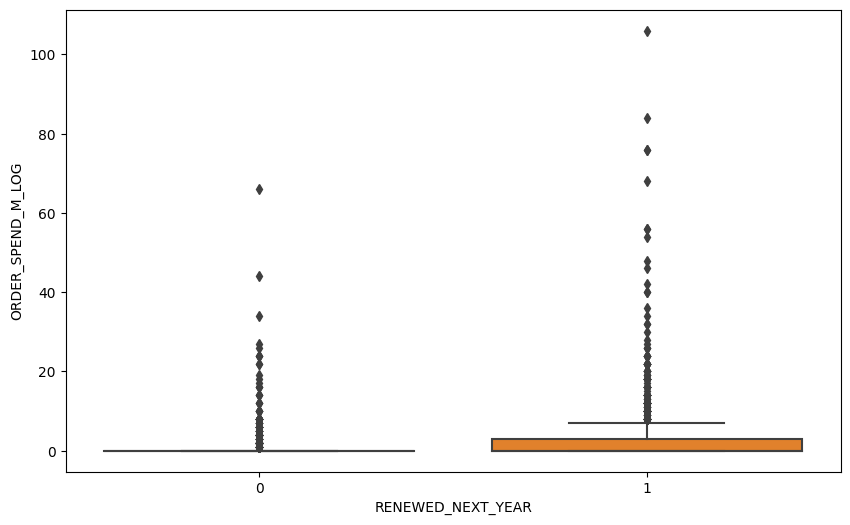

In [27]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_features['RENEWED_NEXT_YEAR'], y=df_features['COUNT_SINGLE_ADVANCE'])#.replace(-np.inf, 0))
plt.xlabel('RENEWED_NEXT_YEAR')
plt.ylabel('ORDER_SPEND_M_LOG')
plt.show()

c:\Users\dgilbert\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


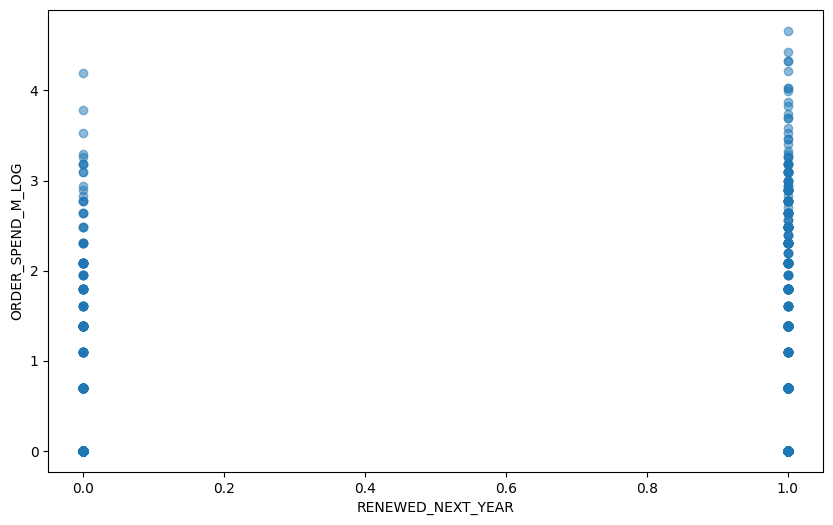

In [28]:
plt.figure(figsize=(10, 6))
plt.scatter(df_features['RENEWED_NEXT_YEAR'], np.log(df_features['COUNT_SINGLE_ADVANCE']).replace(-np.inf, 0), alpha=0.5)
plt.xlabel('RENEWED_NEXT_YEAR')
plt.ylabel('ORDER_SPEND_M_LOG')
plt.show()

In [29]:
#df_features['AVG_ORDER_SPEND_LOG'] = np.log(df_features['AVG_ORDER_SPEND'])
#df_features['AVG_ORDER_SPEND_LOG'] = df_features['AVG_ORDER_SPEND_LOG'].replace(-np.inf, 0)
df_features['TICKET_SPEND_T'].max()

56145.18

## Model

Diff Feature combos and the preproccessing for them

In [30]:
"""
Feature combo 1:
Tenure (Yrs), Attendance Rate, Order Spend (Raw), Ticket Spend (Raw)

Feature combo 2:
Tenure (Yrs), Attendance Rate, Log(Order Spend), Log(Ticket Spend)

Pre-processing for logs of vars:
df_features['TICKET_SPEND_T_LOG'] = np.log(df_features['TICKET_SPEND_T'])
df_features['ORDER_SPEND_M_LOG'] = np.log(df_features['ORDER_SPEND_M'])
df_features['ORDER_SPEND_M_LOG'] = df_features['ORDER_SPEND_M_LOG'].replace(-np.inf, 0)

Feature combo 2.5:
Tenure (Yrs), Attendance Rate, Order Spend, Log(Ticket Spend)

Feature Combo 3:
Tenure (Yrs), Attendance Rate, Avg Order Spend, Avg Ticket Spend

Pre-processing for avgs of vars:
df_features['AVG_TICKET_SPEND'] = df_features['TICKET_SPEND_T']/df_features['TICKET_QUANTITY_T']
df_features['AVG_ORDER_SPEND'] = df_features['ORDER_SPEND_M']/df_features['ORDER_QUANTITY_M']
df_features['AVG_ORDER_SPEND'] = df_features['AVG_ORDER_SPEND'].fillna(0)

Feature Combo 4:
Tenure (Yrs), Attendance Rate, Log(Avg Order Spend), Log(Avg Ticket Spend)

Pre-processing for Log(avgs) of vars:
df_features['AVG_TICKET_SPEND_LOG'] = np.log(df_features['AVG_TICKET_SPEND'])
df_features['AVG_ORDER_SPEND_LOG'] = np.log(df_features['AVG_ORDER_SPEND'])
df_features['AVG_ORDER_SPEND_LOG'] = df_features['AVG_ORDER_SPEND_LOG'].replace(-np.inf, 0)

Feature Combo 5:
Tenure (Yrs), Attendance Rate, Avg Order Spend, Ticket Spend/GM

Pre-proccessing:
df_features['TICKET_SPEND_PER_GAME'] = df_features['TICKET_SPEND_T']/games_22
df_features['AVG_ORDER_SPEND'] = df_features['ORDER_SPEND_M']/df_features['ORDER_QUANTITY_M']
df_features['AVG_ORDER_SPEND'] = df_features['AVG_ORDER_SPEND'].fillna(0)

Feature Combo 6:
Tenure (Yrs), Attendance Rate, Order Spend - Encoded, Avg Ticket Spend

Pre-processing:
def categorize_spend(spend):
    if spend == 0:
        return 'No Purchase'
    elif spend <= 100:  # example threshold
        return 'Low'
    elif spend <= 300:  # example threshold
        return 'Medium'
    else:
        return 'High'

df_features['AVG_ORDER_SPEND_CAT'] = df_features['AVG_ORDER_SPEND'].apply(categorize_spend)
df_features = pd.get_dummies(df_features, columns=['AVG_ORDER_SPEND_CAT'])
df_features['AVG_ORDER_SPEND_CAT_High'] = df_features['AVG_ORDER_SPEND_CAT_High'].astype(int)
df_features['AVG_ORDER_SPEND_CAT_Medium'] = df_features['AVG_ORDER_SPEND_CAT_Medium'].astype(int)
df_features['AVG_ORDER_SPEND_CAT_Low'] = df_features['AVG_ORDER_SPEND_CAT_Low'].astype(int)
df_features['AVG_ORDER_SPEND_CAT_No Purchase'] = df_features['AVG_ORDER_SPEND_CAT_No Purchase'].astype(int)

Feature Combo 7:
Tenure (Yrs), Attendance Rate, Order Spend - Encoded, Ticket Spend/Game

Feature Combo 8:
Tenure (Yrs), Attendance Rate, Order Spend - Encoded, Log(Spend/GM)

Pre-proccessing:
df_features['TICKET_SPEND_PER_GAME_LOG'] = np.log(df_features['TICKET_SPEND_PER_GAME'])

Feature Combo 9:

Pre-proccessing
df_features['TICKET_SPEND_PER_GAME'] = df_features['TICKET_SPEND_T']/games_22
df_features['TICKET_SPEND_PER_GAME_LOG'] = np.log(df_features['TICKET_SPEND_PER_GAME'])
df_features['COUNT_SINGLE_ADVANCE_LOG'] = np.log(df_features['COUNT_SINGLE_ADVANCE']).replace(-np.inf, 0)
df_features['COUNT_COMPLIMENTARY_LOG'] = np.log(df_features['COUNT_COMPLIMENTARY']).replace(-np.inf, 0)
df_features['TASK_COUNT_EMAIL_LOG'] = np.log(df_features['TASK_COUNT_EMAIL']).replace(-np.inf, 0)
df_features['TASK_COUNT_CALL_LOG'] = np.log(df_features['TASK_COUNT_CALL']).replace(-np.inf, 0)
df_features['TASK_COUNT_TASK_LOG'] = np.log(df_features['TASK_COUNT_TASK']).replace(-np.inf, 0)
df_features['TASK_COUNT_CADENCE_LOG'] = np.log(df_features['TASK_COUNT_CADENCE']).replace(-np.inf, 0)
"""

"\nFeature combo 1:\nTenure (Yrs), Attendance Rate, Order Spend (Raw), Ticket Spend (Raw)\n\nFeature combo 2:\nTenure (Yrs), Attendance Rate, Log(Order Spend), Log(Ticket Spend)\n\nPre-processing for logs of vars:\ndf_features['TICKET_SPEND_T_LOG'] = np.log(df_features['TICKET_SPEND_T'])\ndf_features['ORDER_SPEND_M_LOG'] = np.log(df_features['ORDER_SPEND_M'])\ndf_features['ORDER_SPEND_M_LOG'] = df_features['ORDER_SPEND_M_LOG'].replace(-np.inf, 0)\n\nFeature combo 2.5:\nTenure (Yrs), Attendance Rate, Order Spend, Log(Ticket Spend)\n\nFeature Combo 3:\nTenure (Yrs), Attendance Rate, Avg Order Spend, Avg Ticket Spend\n\nPre-processing for avgs of vars:\ndf_features['AVG_TICKET_SPEND'] = df_features['TICKET_SPEND_T']/df_features['TICKET_QUANTITY_T']\ndf_features['AVG_ORDER_SPEND'] = df_features['ORDER_SPEND_M']/df_features['ORDER_QUANTITY_M']\ndf_features['AVG_ORDER_SPEND'] = df_features['AVG_ORDER_SPEND'].fillna(0)\n\nFeature Combo 4:\nTenure (Yrs), Attendance Rate, Log(Avg Order Spend), 

### Comparison

We are looking at the Log loss and Accuracy Rates for Binary Classifiers, Random Forests, and Decision Trees with 1-50 stratified folds (handling class imbalance). Check Spreadsheet for results of minimum # of stratified folds with highest accuracy and lowest log loss combos

In [31]:
def categorize_spend(spend):
    if spend == 0:
        return 'No Purchase'
    elif spend <= 100:  # example threshold
        return 'Low'
    elif spend <= 300:  # example threshold
        return 'Medium'
    else:
        return 'High'
df_features['AVG_ORDER_SPEND'] = df_features['ORDER_SPEND_M']/df_features['ORDER_QUANTITY_M']
df_features['AVG_ORDER_SPEND'] = df_features['AVG_ORDER_SPEND'].fillna(0)
df_features['AVG_ORDER_SPEND_CAT'] = df_features['AVG_ORDER_SPEND'].apply(categorize_spend)
df_features = pd.get_dummies(df_features, columns=['AVG_ORDER_SPEND_CAT'])
df_features['AVG_ORDER_SPEND_CAT_High'] = df_features['AVG_ORDER_SPEND_CAT_High'].astype(int)
df_features['AVG_ORDER_SPEND_CAT_Medium'] = df_features['AVG_ORDER_SPEND_CAT_Medium'].astype(int)
df_features['AVG_ORDER_SPEND_CAT_Low'] = df_features['AVG_ORDER_SPEND_CAT_Low'].astype(int)
df_features['AVG_ORDER_SPEND_CAT_No Purchase'] = df_features['AVG_ORDER_SPEND_CAT_No Purchase'].astype(int)

In [32]:
df_features['TENURE_LOG'] = np.log(df_features['MLS_TENURE_YEARS'])
df_features['TICKET_SPEND_PER_GAME'] = df_features['TICKET_SPEND_T']/games_22
df_features['TICKET_SPEND_PER_GAME_LOG'] = np.log(df_features['TICKET_SPEND_PER_GAME'])
df_features['COUNT_SINGLE_ADVANCE_LOG'] = np.log(df_features['COUNT_SINGLE_ADVANCE']).replace(-np.inf, 0)
df_features['COUNT_COMPLIMENTARY_LOG'] = np.log(df_features['COUNT_COMPLIMENTARY']).replace(-np.inf, 0)
df_features['TASK_COUNT_EMAIL_LOG'] = np.log(df_features['TASK_COUNT_EMAIL']).replace(-np.inf, 0)
df_features['TASK_COUNT_CALL_LOG'] = np.log(df_features['TASK_COUNT_CALL']).replace(-np.inf, 0)
df_features['TASK_COUNT_TASK_LOG'] = np.log(df_features['TASK_COUNT_TASK']).replace(-np.inf, 0)
df_features['TASK_COUNT_CADENCE_LOG'] = np.log(df_features['TASK_COUNT_CADENCE']).replace(-np.inf, 0)
X = df_features[['ATTENDANCE_RATE', 'AVG_ORDER_SPEND_CAT_High', 'AVG_ORDER_SPEND_CAT_Low', 'AVG_ORDER_SPEND_CAT_Medium', 'AVG_ORDER_SPEND_CAT_No Purchase', 
                 'TICKET_SPEND_PER_GAME_LOG', 
                 'TENURE_LOG', 
                 'COUNT_SINGLE_ADVANCE_LOG', #'COUNT_COMPLIMENTARY_LOG', 
                 'TASK_COUNT_EMAIL_LOG', 
                 'TASK_COUNT_CALL_LOG', 'TASK_COUNT_TASK_LOG', 'TASK_COUNT_CADENCE_LOG']]
y = df_features['RENEWED_NEXT_YEAR']

random_state = 1010

models = [
    ("Logistic Regression", LogisticRegression(max_iter=1000))#,
#    ("Random Forest", RandomForestClassifier()),
 #   ("Decision Tree", DecisionTreeClassifier())
]

mean_accuracy_results = {name: [] for name, _ in models}
mean_log_loss_results = {name: [] for name, _ in models}
random_state = 1010

for i in tqdm(range(2, 51), desc='Progress'):
    kf = StratifiedKFold(n_splits=i, random_state=random_state, shuffle=True)

    accuracy_results = {name: [] for name, _ in models}
    log_loss_results = {name: [] for name, _ in models}
    coef_results = {name: [] for name, _ in models}

    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        for name, model in models:
            model.fit(X_train, y_train)
            predictions = model.predict(X_test)
            accuracy = accuracy_score(y_test, predictions)
            loss = log_loss(y_test, predictions, labels=[0, 1])

            coef_results[name].append(model.coef_)
            accuracy_results[name].append(accuracy)
            log_loss_results[name].append(loss)

    # after running all folds for a given number, compute the mean for each model
    for name in accuracy_results:
        mean_accuracy_results[name].append(np.mean(accuracy_results[name]))
        mean_log_loss_results[name].append(np.mean(log_loss_results[name]))

c:\Users\dgilbert\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\dgilbert\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\dgilbert\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\dgilbert\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\dgilbert\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result

Progress: 100%|██████████| 49/49 [01:34<00:00,  1.92s/it]


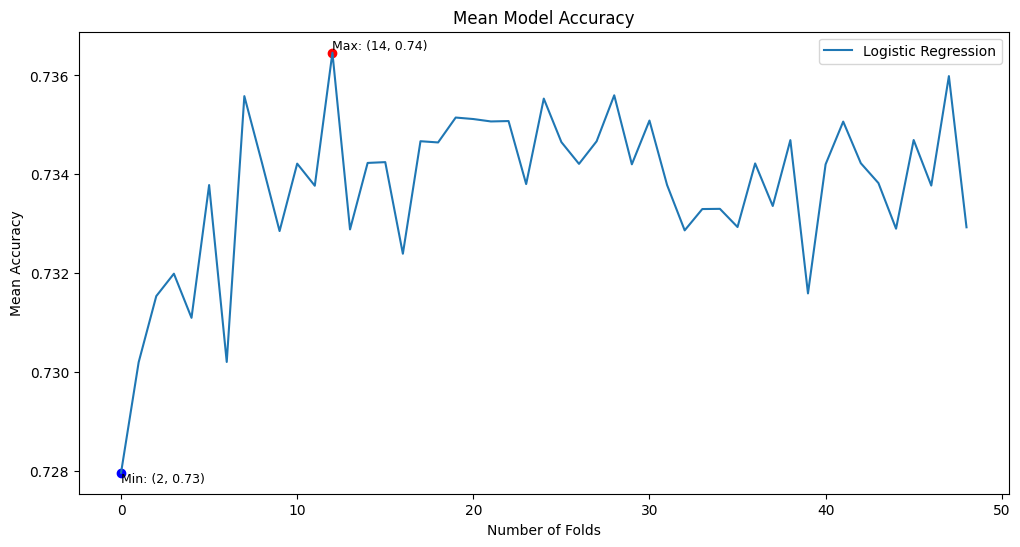

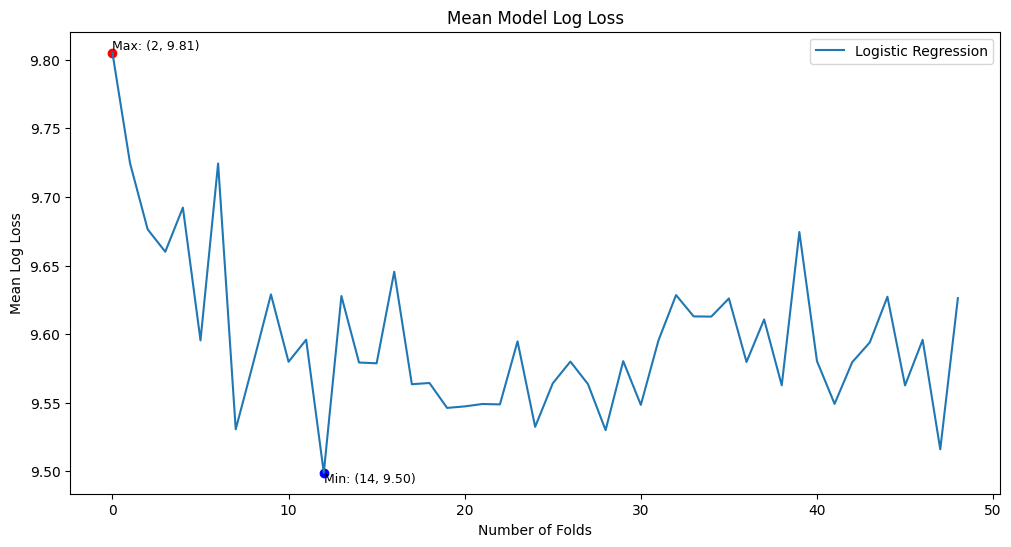

In [33]:
# now plot mean_accuracy_results and mean_log_loss_results
plt.figure(figsize=(12, 6))
for name, accuracies in mean_accuracy_results.items():
    plt.plot(accuracies, label=name)
    
    # Find index and value of min and max accuracy
    max_acc_index, max_acc = max(enumerate(accuracies), key=lambda pair: pair[1])
    min_acc_index, min_acc = min(enumerate(accuracies), key=lambda pair: pair[1])
    
    # Highlight max and min points
    plt.scatter(max_acc_index, max_acc, color='red')
    plt.text(max_acc_index, max_acc, f'Max: ({max_acc_index+2}, {max_acc:.2f})', fontsize=9, va='bottom')
    
    plt.scatter(min_acc_index, min_acc, color='blue')
    plt.text(min_acc_index, min_acc, f'Min: ({min_acc_index+2}, {min_acc:.2f})', fontsize=9, va='top')

plt.title('Mean Model Accuracy')
plt.ylabel('Mean Accuracy')
plt.xlabel('Number of Folds')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
for name, losses in mean_log_loss_results.items():
    plt.plot(losses, label=name)
    
    # Find index and value of min and max log loss
    max_loss_index, max_loss = max(enumerate(losses), key=lambda pair: pair[1])
    min_loss_index, min_loss = min(enumerate(losses), key=lambda pair: pair[1])
    
    # Highlight max and min points
    plt.scatter(max_loss_index, max_loss, color='red')
    plt.text(max_loss_index, max_loss, f'Max: ({max_loss_index+2}, {max_loss:.2f})', fontsize=9, va='bottom')
    
    plt.scatter(min_loss_index, min_loss, color='blue')
    plt.text(min_loss_index, min_loss, f'Min: ({min_loss_index+2}, {min_loss:.2f})', fontsize=9, va='top')

plt.title('Mean Model Log Loss')
plt.ylabel('Mean Log Loss')
plt.xlabel('Number of Folds')
plt.legend()
plt.show()

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Compute VIF
vif = pd.DataFrame()
vif["variables"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)


                   variables        VIF
0            ATTENDANCE_RATE   3.019482
1  TICKET_SPEND_PER_GAME_LOG  10.490296
2                 TENURE_LOG   5.611984
3   COUNT_SINGLE_ADVANCE_LOG   1.369723
4       TASK_COUNT_EMAIL_LOG   3.896760
5        TASK_COUNT_CALL_LOG  15.864021
6        TASK_COUNT_TASK_LOG   3.200637


In [34]:
import statsmodels.api as sm

# Initialize a list to store the models' summaries
summary_results = []

# Set the number of splits to 3
kf = StratifiedKFold(n_splits=14, random_state=random_state, shuffle=True)

X = df_features[['ATTENDANCE_RATE', 'AVG_ORDER_SPEND_CAT_High', 'AVG_ORDER_SPEND_CAT_Low', 'AVG_ORDER_SPEND_CAT_Medium', 'AVG_ORDER_SPEND_CAT_No Purchase', 
                 'TICKET_SPEND_PER_GAME_LOG', 
                 'TENURE_LOG', 
                 'COUNT_SINGLE_ADVANCE_LOG', #'COUNT_COMPLIMENTARY_LOG', 
                 'TASK_COUNT_EMAIL_LOG', 
                 'TASK_COUNT_CALL_LOG', 'TASK_COUNT_TASK_LOG', 'TASK_COUNT_CADENCE_LOG']]
y = df_features['RENEWED_NEXT_YEAR']

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Add constant to the train dataset for the intercept
    X_train_sm = sm.add_constant(X_train)

    # Fit logistic regression model using statsmodels
    model = sm.Logit(y_train, X_train_sm)
    result = model.fit()
    
    # Save the model's summary
    summary_results.append(result.summary())

# Access the model summary at the 3rd fold
# Note: Python indexing starts at 0, so for the 3rd fold, the index would be 2.
third_fold_summary = summary_results[2]
print(third_fold_summary)

Optimization terminated successfully.
         Current function value: 0.522170
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.529239
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.525063
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.517899
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.521525
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.526236
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.526584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.528731
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.518626
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.524198
 

In [35]:
# Add constant to the test dataset for the intercept
X_test_sm = sm.add_constant(X_test)

# Get predictions on test data
y_pred = result.predict(X_test_sm)

# Convert predictions to binary 0/1
y_pred_binary = [1 if p > 0.5 else 0 for p in y_pred]

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_binary)

print(f"Accuracy: {accuracy}")

Accuracy: 0.7044025157232704


In [ ]:
#print(accuracy_results['Logistic Regression'].index(max(accuracy_results['Logistic Regression'])), max(accuracy_results['Logistic Regression']))

('Logistic Regression', LogisticRegression(max_iter=1000))

In [ ]:
mean_log_loss_results
#print(loss_results['Logistic Regression'].index(min(loss_results['Logistic Regression'])), min(loss_results['Logistic Regression']))

20 3.276695762647014
